In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [2]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [3]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [4]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

Target reader ratings: 166
Matching on book_id: 30
Matching on title: 65
Total matches: 95, 57.23% of total


In [5]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Functions to Process Recommendations

In [6]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([3-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [7]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [8]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [9]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    
    sns.barplot(
        data=neighbor_genre_ranking, y=neighbor_genre_ranking.index, x=0, ax=ax[0]
    )
    ax[0].set_xlabel("Genre preference")
    ax[0].set_title("Neighbors' Top Genres")

    # Plot target reader's top genres    
    sns.barplot(
        data=target_genre_ranking, y=target_genre_ranking.index, x=0, ax=ax[1]
    )
    ax[1].set_xlabel("Genre preference")
    ax[1].set_title("Target User's Top Genres")
    
    plt.show()

## Part 1 - User:User Collaborative Filtering with KNN

### 1.1 - Generate Recommendations from Similar Readers

In [10]:
# Perform KNN on user rating matrix
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_39001/903381106.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_39001/903381106.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


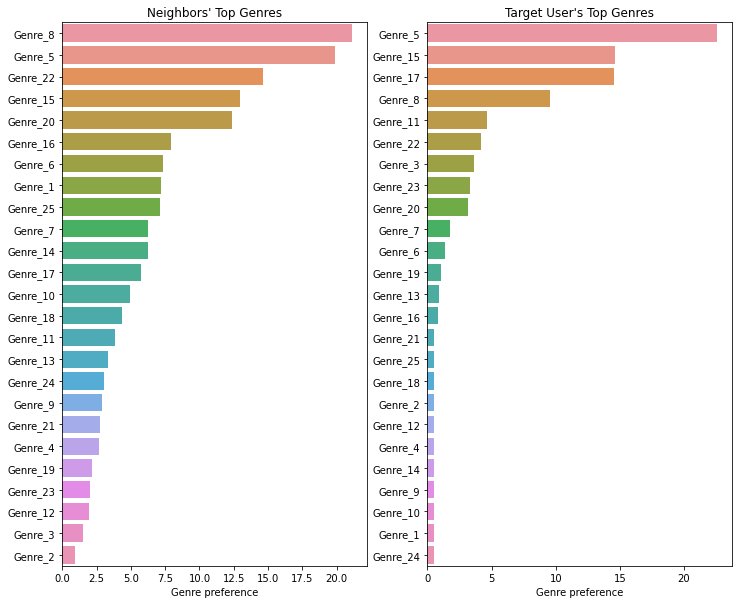

In [11]:
# Show top genres
plot_top_genres(neighbor_user_ratings, target_user_ratings)

In [12]:
# View most popular books among neighbors
neighbors_most_popular(neighbor_user_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
49,Secrets of a Side Bitch 3,4.58,1181.0,2014,1.6%,https://www.goodreads.com/book/show/20934376-s...
48,Secrets of a Side Bitch 2,4.54,1419.0,2013,1.6%,https://www.goodreads.com/book/show/18781068-s...
86,War's Unwomanly Face,4.52,1182.0,1988,1.6%,https://www.goodreads.com/book/show/4025275-wa...
34,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,1.6%,https://www.goodreads.com/book/show/24611623-i...
6,Assata: An Autobiography,4.47,11057.0,1999,1.6%,https://www.goodreads.com/book/show/100322.Assata
89,"Who We Are (Bear, Otter, and the Kid, #2)",4.47,4184.0,2012,1.6%,https://www.goodreads.com/book/show/13579947-w...
52,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.6%,https://www.goodreads.com/book/show/27220736-s...
5,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,2015,1.6%,https://www.goodreads.com/book/show/17836520-a...
38,My Journey : Transforming Dreams into Actions,4.35,1743.0,2013,1.6%,https://www.goodreads.com/book/show/18371021-m...
84,"Traitor to the Throne (Rebel of the Sands, #2)",4.35,4825.0,2017,1.6%,https://www.goodreads.com/book/show/29739361-t...


In [13]:
# Highest rated books among similar readers
neighbors_top_rated(neighbor_user_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
49,Secrets of a Side Bitch 3,4.58,1181.0,2014,https://www.goodreads.com/book/show/20934376-s...
48,Secrets of a Side Bitch 2,4.54,1419.0,2013,https://www.goodreads.com/book/show/18781068-s...
86,War's Unwomanly Face,4.52,1182.0,1988,https://www.goodreads.com/book/show/4025275-wa...
34,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,https://www.goodreads.com/book/show/24611623-i...
6,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
89,"Who We Are (Bear, Otter, and the Kid, #2)",4.47,4184.0,2012,https://www.goodreads.com/book/show/13579947-w...
52,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
5,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,2015,https://www.goodreads.com/book/show/17836520-a...
38,My Journey : Transforming Dreams into Actions,4.35,1743.0,2013,https://www.goodreads.com/book/show/18371021-m...
84,"Traitor to the Throne (Rebel of the Sands, #2)",4.35,4825.0,2017,https://www.goodreads.com/book/show/29739361-t...


In [15]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=neighbor_user_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
19,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
8,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
20,Why I Am An Atheist: An Autobiographical Disco...,4.45,866.0,https://www.goodreads.com/book/show/1389596.Wh...
12,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
6,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,https://www.goodreads.com/book/show/4373.First...
16,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
10,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
18,Time Stops at Shamli and Other Stories,4.11,1091.0,https://www.goodreads.com/book/show/475218.Tim...
11,Scheisshaus Luck: Surviving the Unspeakable in...,4.09,1049.0,https://www.goodreads.com/book/show/3930572-sc...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
11,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
9,Srikanta,4.23,1004.0,https://www.goodreads.com/book/show/1417962.Sr...
2,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
4,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
12,The Purity Myth: How America's Obsession with ...,4.06,5741.0,https://www.goodreads.com/book/show/4914761-th...
0,Alice in Wonderland,4.03,346530.0,https://www.goodreads.com/book/show/13023.Alic...
13,Voyage of the Beagle,4.03,4417.0,https://www.goodreads.com/book/show/183645.Voy...
8,Octavia's Brood: Science Fiction Stories from ...,3.94,1088.0,https://www.goodreads.com/book/show/23129839-o...
3,"Go Down, Moses",3.93,7562.0,https://www.goodreads.com/book/show/17726.Go_D...
7,Nervous Conditions,3.92,6949.0,https://www.goodreads.com/book/show/158674.Ner...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
0,"By Schism Rent Asunder (Safehold, #2)",4.10,5410.0,https://www.goodreads.com/book/show/2381756.By...
5,"The Light Fantastic (Discworld, #2; Rincewind #2)",3.94,76808.0,https://www.goodreads.com/book/show/34506.The_...
4,"The Clockwork Universe: Isaac Newton, the Roya...",3.91,3763.0,https://www.goodreads.com/book/show/9449985-th...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
12,The (7L) The Seven Levels of Communication: Go...,4.33,482.0,https://www.goodreads.com/book/show/9858250-th...
19,Totto-chan: The Little Girl at the Window,4.30,14456.0,https://www.goodreads.com/book/show/328802.Tot...
0,"""I Give You My Body . . ."": How I Write Sex Sc...",4.21,481.0,https://www.goodreads.com/book/show/30719827-i...
6,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
1,Continuous Delivery: Reliable Software Release...,4.15,1748.0,https://www.goodreads.com/book/show/8686650-co...
17,Things No One Will Tell Fat Girls: A Handbook ...,4.06,1488.0,https://www.goodreads.com/book/show/24796533-t...
15,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,https://www.goodreads.com/book/show/10127019-t...
16,The Rational Optimist: How Prosperity Evolves,3.98,4894.0,https://www.goodreads.com/book/show/7776209-th...
11,Thank You for Being Late: An Optimist's Guide ...,3.96,3010.0,https://www.goodreads.com/book/show/26114127-t...
4,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0,https://www.goodreads.com/book/show/1202.Freak...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url


_____



## Part 2 - User:Item Collaborative Filtering with Matrix Factorization

#### 2.1 - Matrix Factorization with SVD

In [16]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
large_neighborhood_ratings, target_user_ratings = find_neighbors(2000, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_39001/903381106.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_39001/903381106.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [17]:
# Get unique users and books to slice df_reviews
neighbor_index = large_neighborhood_ratings["uid"].unique()
neighbor_index = np.append(neighbor_index, target)
neighbor_book_index = large_neighborhood_ratings["book_index"].unique()
neighbor_book_index = np.append(neighbor_book_index, target_user_ratings["book_index"].unique())

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, neighbor_book_index]
R = R[neighbor_index, :]

In [18]:
# Decompose user ratings matrix R
U, sigma, Vt = svds(R, k=5)
sigma = np.diag(sigma)

U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [19]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=neighbor_book_index, index=neighbor_index)\
                .reset_index()

In [20]:
# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(
                    df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                    on="book_id"
                )\
                .drop(columns=["index", "book_id"])

# Filter out already read books
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
top_preds.drop(["book_index"], axis=1, inplace=True)

# Write to excel
path = wd + "/data/book_recs.xlsx"
if os.path.isfile(path):
    with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
        top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
            .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
else:
    with pd.ExcelWriter(path) as writer:
        top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
            .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
writer.close

top_preds.query("avg_rating > 3.9").head(20)    

,predicted_rating,title,avg_rating,ratings_count,year,main_genre,url
5,0.010459,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0,2013,5.0,https://www.goodreads.com/book/show/17851885-i...
7,0.008074,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,2002,22.0,https://www.goodreads.com/book/show/10572.A_Cl...
8,0.006290,Night (The Night Trilogy #1),4.30,708754.0,1958,20.0,https://www.goodreads.com/book/show/1617.Night
9,0.005370,Wonder (Wonder #1),4.43,255461.0,2012,16.0,https://www.goodreads.com/book/show/11387515-w...
11,0.004775,The Gunslinger,3.98,346978.0,1982,3.0,https://www.goodreads.com/book/show/43615.The_...
12,0.004714,"I, Robot (Robot #0.1)",4.17,201196.0,2004,17.0,https://www.goodreads.com/book/show/41804.I_Robot
13,0.004662,Bad Feminist,3.91,43988.0,2014,16.0,https://www.goodreads.com/book/show/18813642-b...
15,0.004614,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0,2006,8.0,https://www.goodreads.com/book/show/1202.Freak...
17,0.004141,Mom & Me & Mom,4.15,10192.0,2013,20.0,https://www.goodreads.com/book/show/15798797-m...
20,0.003709,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,7.0,https://www.goodreads.com/book/show/5043.The_P...


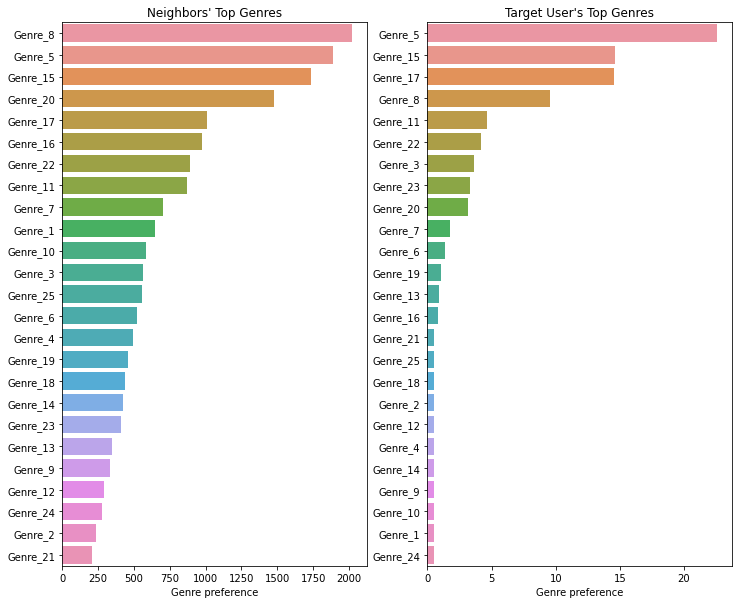

In [21]:
# Show top genres
plot_top_genres(large_neighborhood_ratings, target_user_ratings)

In [22]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(large_neighborhood_ratings, 50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
1642,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0,2013,2.8%,https://www.goodreads.com/book/show/17851885-i...
413,Bad Feminist,3.91,43988.0,2014,2.5%,https://www.goodreads.com/book/show/18813642-b...
4821,Wonder (Wonder #1),4.43,255461.0,2012,2.1%,https://www.goodreads.com/book/show/11387515-w...
50,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,2002,2.0%,https://www.goodreads.com/book/show/10572.A_Cl...
2246,Night (The Night Trilogy #1),4.30,708754.0,1958,1.7%,https://www.goodreads.com/book/show/1617.Night
3605,The Gunslinger,3.98,346978.0,1982,1.6%,https://www.goodreads.com/book/show/43615.The_...
256,All the Ugly and Wonderful Things,4.10,35002.0,2016,1.4%,https://www.goodreads.com/book/show/26114135-a...
3577,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,1.4%,https://www.goodreads.com/book/show/15819028-t...
3052,Talking as Fast as I Can: From Gilmore Girls t...,4.03,35052.0,2016,1.4%,https://www.goodreads.com/book/show/30253864-t...
3969,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,1.3%,https://www.goodreads.com/book/show/5043.The_P...


In [23]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(large_neighborhood_ratings, 50, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
4057,The Revenge of the Baby-Sat,4.71,11626.0,1991,https://www.goodreads.com/book/show/121792.The...
2692,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
4887,Yukon Ho!,4.70,8983.0,1989,https://www.goodreads.com/book/show/70491.Yuko...
3382,The Days Are Just Packed: A Calvin and Hobbes ...,4.69,19336.0,1993,https://www.goodreads.com/book/show/24818.The_...
4345,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011,https://www.goodreads.com/book/show/9329354-th...
1647,I Dissent: Ruth Bader Ginsburg Makes Her Mark,4.67,1665.0,2016,https://www.goodreads.com/book/show/28210996-i...
3778,The Life and Times of Scrooge McDuck,4.67,2047.0,2005,https://www.goodreads.com/book/show/5309.The_L...
3649,The Holy Bible: English Standard Version,4.66,18613.0,2007,https://www.goodreads.com/book/show/5883777-th...
1909,Letter from the Birmingham Jail,4.64,2776.0,1994,https://www.goodreads.com/book/show/203899.Let...
3460,The Essential Calvin and Hobbes: A Calvin and ...,4.64,95116.0,1988,https://www.goodreads.com/book/show/43070.The_...


In [24]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    large_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.15, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=True
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
32,Persepolis: The Story of a Childhood (Persepol...,4.23,119470.0,https://www.goodreads.com/book/show/9516.Perse...
35,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
54,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
70,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
78,Hitler's Empire: How the Nazis Ruled Europe,4.16,1591.0,https://www.goodreads.com/book/show/3039027-hi...
80,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
101,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,https://www.goodreads.com/book/show/11472.We_W...
114,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
124,Tears We Cannot Stop: A Sermon to White America,4.34,2498.0,https://www.goodreads.com/book/show/31421117-t...
133,"The Prize: The Epic Quest for Oil, Money, and ...",4.40,5329.0,https://www.goodreads.com/book/show/169354.The...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
23,Arguably: Selected Essays,4.19,6061.0,https://www.goodreads.com/book/show/10383597-a...
33,Why Evolution Is True,4.16,15226.0,https://www.goodreads.com/book/show/4005310-wh...
43,Memoirs of Hadrian,4.25,8321.0,https://www.goodreads.com/book/show/12172.Memo...
75,Palestine,4.20,10082.0,https://www.goodreads.com/book/show/769712.Pal...
100,The Road to the Dark Tower: Exploring Stephen ...,4.29,32867.0,https://www.goodreads.com/book/show/452157.The...
128,In the Shadow of Young Girls in Flower (In Sea...,4.40,4461.0,https://www.goodreads.com/book/show/28385.In_t...
144,The Roman Revolution,4.25,483.0,https://www.goodreads.com/book/show/167913.The...
158,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
181,A Field Guide to American Houses,4.28,679.0,https://www.goodreads.com/book/show/1013972.A_...
246,The Philip K. Dick Reader,4.28,2511.0,https://www.goodreads.com/book/show/14183.The_...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
12,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
52,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
61,"Caliban's War (The Expanse, #2)",4.29,41459.0,https://www.goodreads.com/book/show/12591698-c...
256,"Live Free or Die (Troy Rising, #1)",4.16,6544.0,https://www.goodreads.com/book/show/6713634-li...
292,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
321,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.35,189288.0,https://www.goodreads.com/book/show/15196.Maus_I
473,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
474,The Dreaming Void,4.18,16512.0,https://www.goodreads.com/book/show/866136.The...
544,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
664,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
85,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
89,How Not to Die: Discover the Foods Scientifica...,4.53,4467.0,https://www.goodreads.com/book/show/25663961-h...
155,Neurosis and Human Growth: The Struggle Toward...,4.22,603.0,https://www.goodreads.com/book/show/130383.Neu...
259,The Alphabet Versus the Goddess: The Conflict ...,4.18,1611.0,https://www.goodreads.com/book/show/455992.The...
270,The Hard Thing About Hard Things: Building a B...,4.20,20745.0,https://www.goodreads.com/book/show/18176747-t...
279,Algorithms to Live By: The Computer Science of...,4.16,4639.0,https://www.goodreads.com/book/show/25666050-a...
301,If Grace Is True: Why God Will Save Every Pers...,4.20,956.0,https://www.goodreads.com/book/show/111829.If_...
309,Wit,4.20,10771.0,https://www.goodreads.com/book/show/171201.Wit
333,Bigger Leaner Stronger: The Simple Science of ...,4.16,670.0,https://www.goodreads.com/book/show/15745156-b...
410,The Book of Joy: Lasting Happiness in a Changi...,4.34,9067.0,https://www.goodreads.com/book/show/29496453-t...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
84,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
146,Animal Farm / 1984,4.26,120269.0,https://www.goodreads.com/book/show/5472.Anima...
569,The Essential Dykes to Watch Out For,4.36,6979.0,https://www.goodreads.com/book/show/3189884-th...
945,A Manual for Cleaning Women: Selected Stories,4.17,6863.0,https://www.goodreads.com/book/show/22929586-a...
1363,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
1400,The Exploits of Sherlock Holmes,4.41,26933.0,https://www.goodreads.com/book/show/76104.The_...
1499,Cinema Panopticum,4.16,784.0,https://www.goodreads.com/book/show/634790.Cin...
1537,Peter and Alice,4.44,561.0,https://www.goodreads.com/book/show/17347724-p...
1989,A Supposedly Fun Thing I'll Never Do Again: E...,4.28,23746.0,https://www.goodreads.com/book/show/6748.A_Sup...
2218,Ministry of Moral Panic,4.24,557.0,https://www.goodreads.com/book/show/17238889-m...


_____

Genre 22: ['world', 'power', 'enemy', 'war', 'battle', 'evil', 'magic', 'save', 'ancient', 'warrior']


,title,avg_rating,ratings_count,url
7,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,https://www.goodreads.com/book/show/10572.A_Cl...
304,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,https://www.goodreads.com/book/show/26863057-a...
376,The Sword of Summer (Magnus Chase and The Gods...,4.26,921.0,https://www.goodreads.com/book/show/25909686-t...
414,The False Prince (The Ascendance Trilogy #1),4.23,51292.0,https://www.goodreads.com/book/show/12432220-t...
457,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,https://www.goodreads.com/book/show/43841.When...
558,The Shepherd's Crown,4.35,1081.0,https://www.goodreads.com/book/show/25398409-t...
564,"Deadpool, Volume 3: The Good, the Bad and the ...",4.29,1906.0,https://www.goodreads.com/book/show/17899539-d...
651,The Cartel,4.29,9961.0,https://www.goodreads.com/book/show/23602561-t...
714,Time and Chance (Henry II & Eleanor of Aquitai...,4.28,6106.0,https://www.goodreads.com/book/show/234560.Tim...
731,"Sword of Destiny (The Witcher, #2)",4.40,4967.0,https://www.goodreads.com/book/show/18215192-s...


_____

Genre 3: ['collection', 'comic', 'short', 'fan', 'feature', 'bestselling', 'adventure', 'available', 'classic', 'includes']


,title,avg_rating,ratings_count,url
45,The Dark Tower,4.27,96576.0,https://www.goodreads.com/book/show/5091.The_D...
102,A Perfect Day for Bananafish,4.34,6358.0,https://www.goodreads.com/book/show/7875439-a-...
154,Y: The Last Man - The Deluxe Edition Book One,4.36,10549.0,https://www.goodreads.com/book/show/3710603-y
206,Calvin and Hobbes,4.61,120371.0,https://www.goodreads.com/book/show/77727.Calv...
262,"Harry Potter: The Prequel (Harry Potter, #0.5)",4.22,13267.0,https://www.goodreads.com/book/show/8933944-ha...
277,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
412,The Essential Calvin and Hobbes: A Calvin and ...,4.64,95116.0,https://www.goodreads.com/book/show/43070.The_...
471,Saga: Book One,4.70,4201.0,https://www.goodreads.com/book/show/22078240-saga
483,The Kite Runner: Graphic Novel,4.25,6466.0,https://www.goodreads.com/book/show/11296523-t...
617,"The Guild (The Guild, #1)",4.22,4861.0,https://www.goodreads.com/book/show/8693600-th...


_____

Genre 23: ['agent', 'team', 'mission', 'job', 'dead', 'terrorist', 'zombie', 'government', 'secret', 'drug']


,title,avg_rating,ratings_count,url
1365,Never Split the Difference: Negotiating As If ...,4.49,3314.0,https://www.goodreads.com/book/show/26156469-n...
2626,"Dust & Decay (Rot & Ruin, #2)",4.28,13867.0,https://www.goodreads.com/book/show/9917998-du...
2681,"Deadpool, by Daniel Way: The Complete Collecti...",4.25,2185.0,https://www.goodreads.com/book/show/17724777-d...
3060,"The Cartel (The Cartel, #1)",4.58,5703.0,https://www.goodreads.com/book/show/5953477-th...
4188,Daredevil: Born Again,4.31,597.0,https://www.goodreads.com/book/show/6929380-da...
4876,"Lucifer, Book One (Lucifer, #1)",4.24,1708.0,https://www.goodreads.com/book/show/17137616-l...
5212,"Much Obliged, Jeeves",4.24,472.0,https://www.goodreads.com/book/show/16394.Much...
5800,The Legend of Korra: Turf Wars Part One (Turf ...,4.35,1946.0,https://www.goodreads.com/book/show/33161035-t...
5924,"The First Hostage (J. B. Collins, #2)",4.43,1619.0,https://www.goodreads.com/book/show/26043842-t...
6099,Richard Stark’s Parker: The Score,4.28,1919.0,https://www.goodreads.com/book/show/14539948-r...


_____

Genre 20: ['family', 'year', 'child', 'young', 'home', 'past', 'world', 'loss', 'secret', 'friend']


,title,avg_rating,ratings_count,url
8,Night (The Night Trilogy #1),4.30,708754.0,https://www.goodreads.com/book/show/1617.Night
24,Daytripper,4.31,18265.0,https://www.goodreads.com/book/show/8477057-da...
59,Evicted: Poverty and Profit in the American City,4.47,18205.0,https://www.goodreads.com/book/show/25852784-e...
82,The Heart of a Woman,4.19,16156.0,https://www.goodreads.com/book/show/5160.The_H...
113,All But My Life: A Memoir,4.28,14073.0,https://www.goodreads.com/book/show/163363.All...
236,Maus II: A Survivor's Tale: And Here My Troubl...,4.40,93669.0,https://www.goodreads.com/book/show/15197.Maus_II
264,The Chronology of Water,4.20,4956.0,https://www.goodreads.com/book/show/9214995-th...
267,"Ghost Stories (Essex County, #2)",4.20,953.0,https://www.goodreads.com/book/show/1101110.Es...
334,My Journey : Transforming Dreams into Actions,4.35,1743.0,https://www.goodreads.com/book/show/18371021-m...
428,Persepolis 2: The Story of a Return (Persepoli...,4.23,46987.0,https://www.goodreads.com/book/show/9517.Perse...


_____

Genre 7: ['fairy', 'magic', 'adventure', 'world', 'magical', 'die', 'fantasy', 'journey', 'young', 'land']


,title,avg_rating,ratings_count,url
20,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
426,The Tracker,4.17,1309.0,https://www.goodreads.com/book/show/253272.The...
461,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,https://www.goodreads.com/book/show/100915.The...
521,The Sunne in Splendour,4.40,15523.0,https://www.goodreads.com/book/show/119829.The...
592,Uncle Dynamite,4.28,518.0,https://www.goodreads.com/book/show/16241184-u...
626,The Complete Grimm's Fairy Tales,4.31,117324.0,https://www.goodreads.com/book/show/22917.The_...
650,His Dark Materials Trilogy: The Golden Compass...,4.25,4250.0,https://www.goodreads.com/book/show/10074.His_...
892,Pride & Prejudice,4.25,771.0,https://www.goodreads.com/book/show/6909919-pr...
968,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,4.59,92172.0,https://www.goodreads.com/book/show/30.J_R_R_T...
1106,"Out from Boneville (Bone, #1)",4.16,63254.0,https://www.goodreads.com/book/show/106134.Out...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [25]:
R = R.toarray()

In [26]:
def matrix_factorization(R, k=5, steps=4000, lr=0.0002, beta=0.02, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm. Useful explanation
    of the math here: 
    http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/#source-code

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices
    K = k
    P = np.random.rand(R.shape[0],k)
    Q = np.random.rand(R.shape[1],k).T

    for step in range(steps): # For each steps
        r_0 = np.where(R > 0) # Find indices where rating > 0
        e = 0 # Initialize error for step to 0
        i = r_0[0]
        j = r_0[1]
        resid = R[i,j] - (P @ Q)[i,j] # residual is value - r_hat
        e = e + np.sum(pow(resid, 2)) # Add to error
        for k in range(K): # for each component (latent feature)     
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient
            e = e + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Update error with regularized term

        # View progress
        if verbose == 1:            
            if step % (steps / 10) == 0:
                print(f"Step: {int(step + (steps / 10))}, error: {e}")
        
        # Break loop if error is very small
        if e < 0.001:
            break
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [27]:
preds, user_embeddings, item_embeddings = matrix_factorization(R, k=25, steps=8000, verbose=1)

Step: 800, error: 830808.3472613781


In [ ]:
# Make dataframe from predictions and indices
df_preds = pd.DataFrame(preds, columns=neighbor_book_index, index=neighbor_index)\
                .reset_index()

# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(
                    df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                    on="book_id"
                )\
                .drop(columns=["index"])

# View preds on actually read books
target_books_preds = top_preds[top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]\
                        .drop(["book_index"], axis=1)
target_books_preds = pd.merge(target_books_preds, target_user_ratings[["book_id", "user_rating"]], on="book_id")
target_books_preds["diff"] = target_books_preds["predicted_rating"] - target_books_preds["user_rating"]
print("Predictions on Actually Read Books")
display(target_books_preds[["title", "predicted_rating", "user_rating", "diff"]])

# Filter out already read books to get top preds
print("___________\n")
print("Predictions on Unread Books")
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
display(top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
        .query("avg_rating > 3.9").head(20)
    )

In [ ]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    large_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.15, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=True
)